In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.SummaryStats2D import DY
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    full_summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


In [3]:
# # Select summary statistics
# filter_id = [slice(8, 24), slice(56, 68), slice(72, 84)] # tr/pk time stats, decay and propagation fit
# tr_pk_time_ids = np.array([11, 12, 14, 15, 19, 20, 22, 23]) # tr/pk time stats
# filter_id[0] = tr_pk_time_ids
# feat_ids = np.arange(summ_stats.shape[1])
# feat_ids = np.concatenate([feat_ids[idx] for idx in filter_id])
# np.savetxt(os.path.join(TRIAL_PATH, 'TrPkStats_id.txt'), feat_ids, fmt='%d')

In [4]:
# load summary statistics
feat_ids = np.loadtxt(os.path.join(TRIAL_PATH, 'TrPkStats_id.txt'), dtype=int)

In [5]:
summ_stats = full_summ_stats[:, feat_ids]
summ_stats_names = params.SUMM_STATS_NAMES[feat_ids]
df_summ_stats = pd.DataFrame(dict(zip(summ_stats_names, summ_stats.T)))

### Transform labels

In [6]:
label_list = inference_list.copy()

In [7]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0], inplace=True)

with pd.option_context('display.max_rows', 10):
    display(df_la)

ys           d     theta          l_t     lr_pt       r_t  \
507   -88.920498  197.125301  0.232152   712.851300  0.183760  1.365408   
2419  -88.920498  197.125301  0.232152   712.851300  0.183760  1.365408   
1227  -88.920498  197.125301  0.232152   712.851300  0.183760  1.365408   
2899  -88.920498  197.125301  0.232152   712.851300  0.183760  1.365408   
2187  -88.920498  197.125301  0.232152   712.851300  0.183760  1.365408   
...          ...         ...       ...          ...       ...       ...   
4650  278.432928  189.652597 -0.125301  1040.702136  0.202401  0.499717   
1547  278.432928  189.652597 -0.125301  1040.702136  0.202401  0.499717   
2267  278.432928  189.652597 -0.125301  1040.702136  0.202401  0.499717   
3939  278.432928  189.652597 -0.125301  1040.702136  0.202401  0.499717   
5122  278.432928  189.652597 -0.125301  1040.702136  0.202401  0.499717   

         rr_dt  
507   0.748221  
2419  0.748221  
1227  0.748221  
2899  0.748221  
2187  0.748221  
...        ...  
4650  0.726499  
1547  0.726499  
2267  0.726499  
3939  0.726499  
5122  0.726499  

[5975 rows x 7 columns]

## Evaluate correlations

In [8]:
def corr_in_plot(x, y, xy=(.7, .9), ax=None, hue=None, **kwargs):
    """Plot the correlation coefficient at xy location of axis, by default top right"""
    corr = sp.stats.pearsonr(x, y)
    corr = corr.statistic if hasattr(corr, 'statistic') else corr[0]
    ax = ax or plt.gca()
    ax.annotate(f'p={corr:.3f}', xy=xy, xycoords=ax.transAxes)
    return corr

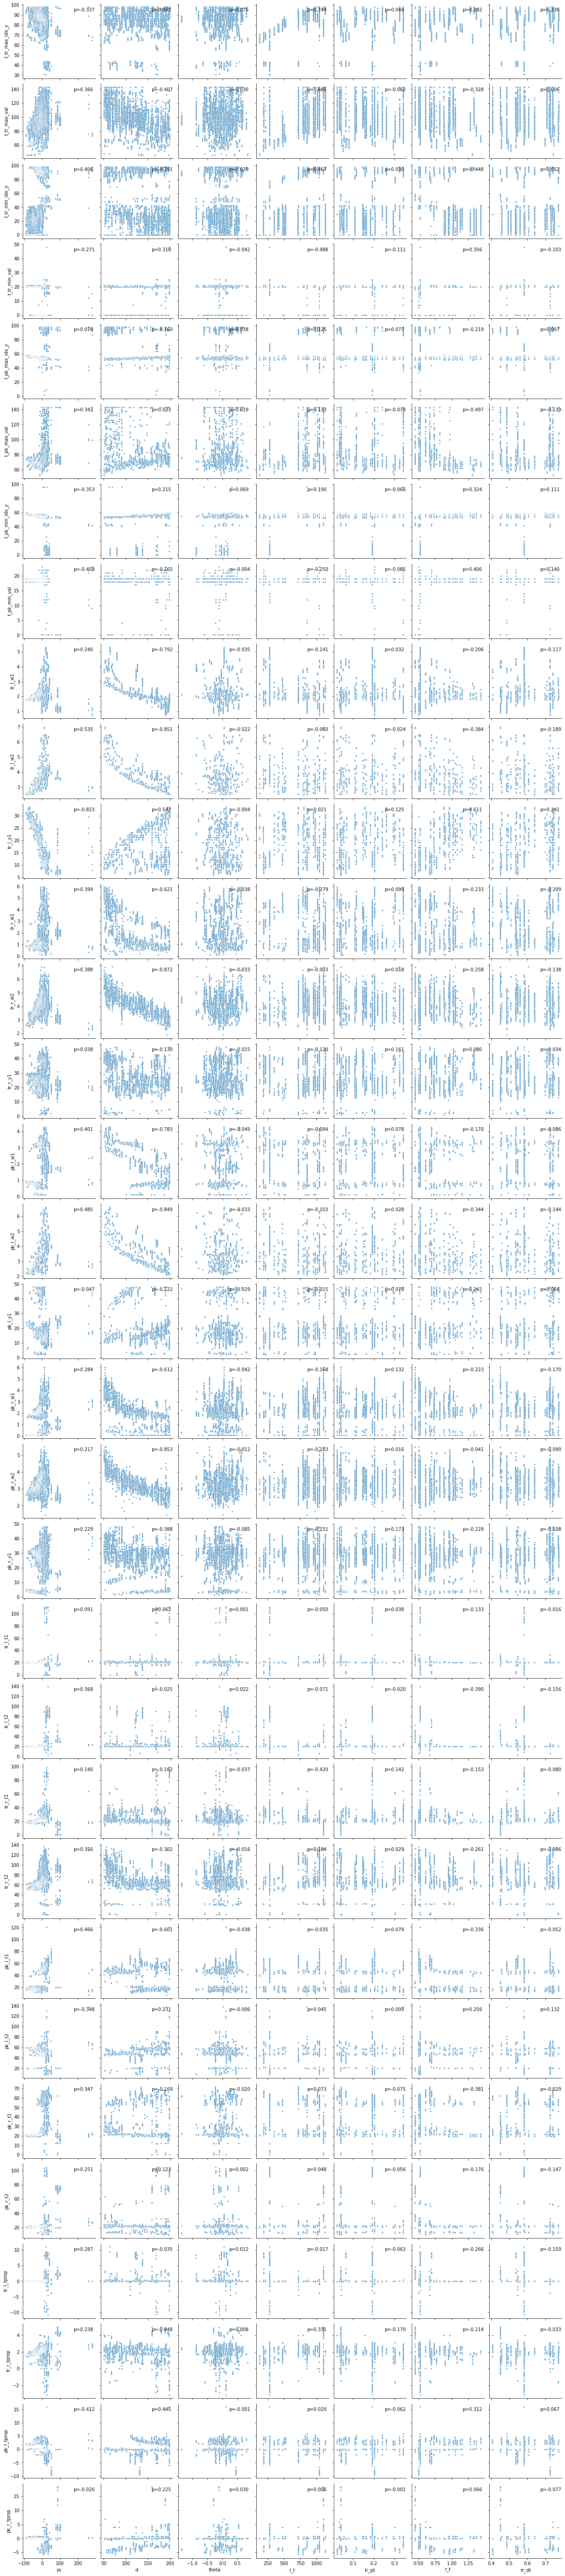

In [9]:
g = sns.pairplot(pd.concat((df_la, df_summ_stats), axis=1),
                 x_vars=label_list, y_vars=summ_stats_names,
                 plot_kws=dict(marker='.'))
g.map(corr_in_plot)
plt.savefig(os.path.join(TRIAL_PATH, 'parameter_feature_correlation.png'))
plt.show()

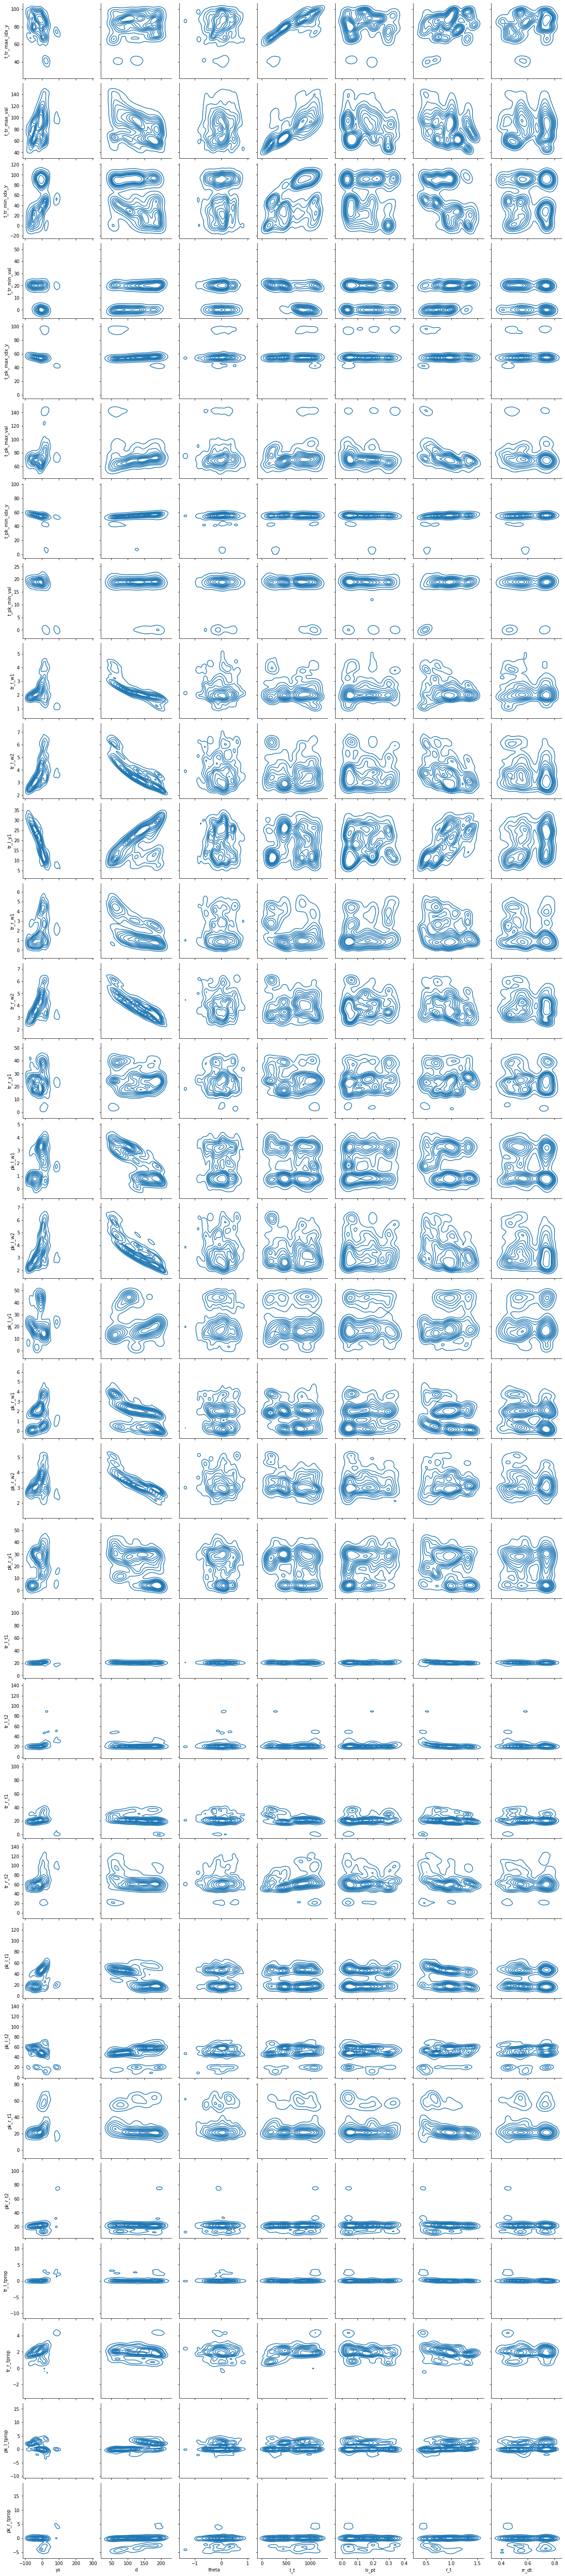

In [10]:
# g = sns.pairplot(pd.concat((df_la, df_summ_stats), axis=1),
#                  x_vars=label_list, y_vars=summ_stats_names,
#                  kind='kde')
# plt.savefig(os.path.join(TRIAL_PATH, 'parameter_feature_kde.png'))
# plt.show()